# Neural Network from Scratch with Numpy

## Imports

In [1]:
%matplotlib inline

import gzip, hashlib, os, requests

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

## Load Data

In [2]:
# Modified from https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb written by George Hotz

def fetch_data(url):
    fp = os.path.join('/tmp', hashlib.md5(url.encode('utf-8')).hexdigest())

    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            data = f.read()
    else:
        with open(fp, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

x_train = fetch_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = fetch_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]

x_test = fetch_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = fetch_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

val_idx = np.random.choice(np.arange(x_train.shape[0]), size=10000, replace=False)
mask = np.zeros(x_train.shape[0], dtype=bool)
mask[val_idx] = True

x_val = x_train[mask]
y_val = y_train[mask]

x_train = x_train[~mask]
y_train = y_train[~mask]

print(f'train shape: {x_train.shape}')
print(f'val shape: {x_val.shape}')
print(f'test shape: {x_test.shape}')

train shape: (50000, 28, 28)
val shape: (10000, 28, 28)
test shape: (10000, 28, 28)


## Normalize

In [3]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

## Preview Data

Label: 5


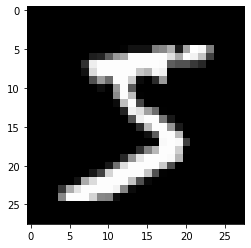

In [4]:
print(f'Label: {y_train[0]}')
img = plt.imshow(x_train[0], cmap='gray', vmin=0, vmax=1)

## Helper Functions

In [5]:
def one_hot(y):
    y_hot = np.zeros((y.size, 10))
    y_hot[np.arange(y.size), y] = 1
    
    return y_hot

def flatten(x):
    return np.reshape(x, (-1, 28 * 28))

## Initialization Functions

In [6]:
def init_random(l1, l2):
    weights = np.random.rand(l1, l2) - 0.5
    biases = np.random.rand(l2) - 0.5
    
    return weights, biases

## Activation Functions

In [7]:
def sigmoid(x, derivative=False):
    if derivative:
        f_x = np.exp(-x) / np.square(np.exp(-x) + 1)
    else:
        f_x = 1 / (np.exp(-x) + 1)

    return f_x

def softmax(x, y=None, derivative=False):
    if derivative:
        f_x = x - y
    else:
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        f_x =  e_x / np.sum(e_x, axis=1, keepdims=True)

    return f_x

## Defining the Network

In [8]:
class NumpyNN:
    def __init__(self, lr, epsilon, init_fn, act_fn):
        self.w1, self.b1 = init_fn(28 * 28, 128)
        self.w2, self.b2 = init_fn(128, 64)
        self.w3, self.b3 = init_fn(64, 10)

        self.lr = lr
        self.epsilon = epsilon
        self.act_fn = act_fn

    def forward(self, x):
        x = flatten(x)

        self.z1 = x @ self.w1 + self.b1
        self.a1 = self.act_fn(self.z1)

        self.z2 = self.a1 @ self.w2 + self.b2
        self.a2 = self.act_fn(self.z2)

        z3 = self.a2 @ self.w3 + self.b3
        self.a3 = softmax(z3)

        return self.a3

    def backward(self, x, y):
        x = flatten(x)
        y_hot = one_hot(y)
        n = y_hot.shape[0]

        dz3 = softmax(self.a3, y_hot, derivative=True)
        self.dw3 = (dz3.T @ self.a2).T / n
        self.db3 = np.sum(dz3, axis=0) / n

        dz2 = (dz3 @ self.w3.T) * self.act_fn(self.z2, derivative=True)
        self.dw2 = (dz2.T @ self.a1).T / n
        self.db2 = np.sum(dz2, axis=0) / n

        dz1 = (dz2 @ self.w2.T) * self.act_fn(self.z1, derivative=True)
        self.dw1 = (dz1.T @ x).T / n
        self.db1 = np.sum(dz1, axis=0) / n

    def update_parameters(self):
        self.w1 -= self.lr * self.dw1
        self.b1 -= self.lr * self.db1
        self.w2 -= self.lr * self.dw2
        self.b2 -= self.lr * self.db2
        self.w3 -= self.lr * self.dw3
        self.b3 -= self.lr * self.db3

    def accuracy(self, y):
        y_hat = np.argmax(self.a3, axis=1)
        accuracy = np.sum(y_hat == y) / y.size

        return accuracy

    def loss(self, y):
        y_hot = one_hot(y)
        losses = -np.sum(y_hot * np.log(self.a3 + self.epsilon), axis=1)
        loss = np.mean(losses)
        
        return loss

## Hyperparameters

In [9]:
lr = 1
epochs = 250
epsilon = 1e-7

## Train Network

In [10]:
model = NumpyNN(lr, epsilon, init_random, sigmoid)
accuracies = []
losses = []

for epoch in range(epochs):
    output = model.forward(x_train)
    model.backward(x_train, y_train)
    model.update_parameters()

    accuracy = model.accuracy(y_train)
    loss = model.loss(y_train)
    accuracies.append(accuracy)
    losses.append(loss)

    accuracy = np.round(accuracy * 100, 2)
    loss = np.round(loss, 4)

    if (epoch + 1) % 10 == 0:
        output = model.forward(x_val)
        val_accuracy = np.round(model.accuracy(y_val) * 100, 2)
        val_loss = np.round(model.loss(y_val), 4)
        print(f'[{epoch + 1}/{epochs}]', end=' ')
        print(f'Train Accuracy: {accuracy}%', end=' ')
        print(f'Train Loss: {loss}', end=' ')
        print(f'Val Accuracy: {val_accuracy}%', end= ' ')
        print(f'Val Loss: {val_loss}')

[10/250] Train Accuracy: 51.46% Train Loss: 1.8356 Val Accuracy: 53.53 Val Loss: 1.7687
[20/250] Train Accuracy: 69.06% Train Loss: 1.2926 Val Accuracy: 69.32 Val Loss: 1.2586
[30/250] Train Accuracy: 66.51% Train Loss: 1.0958 Val Accuracy: 63.49 Val Loss: 1.1423
[40/250] Train Accuracy: 75.86% Train Loss: 0.8275 Val Accuracy: 77.63 Val Loss: 0.8096
[50/250] Train Accuracy: 80.58% Train Loss: 0.6861 Val Accuracy: 81.27 Val Loss: 0.6807
[60/250] Train Accuracy: 82.95% Train Loss: 0.608 Val Accuracy: 83.08 Val Loss: 0.6058
[70/250] Train Accuracy: 84.66% Train Loss: 0.5514 Val Accuracy: 84.58 Val Loss: 0.5494
[80/250] Train Accuracy: 85.97% Train Loss: 0.5081 Val Accuracy: 85.85 Val Loss: 0.5061
[90/250] Train Accuracy: 86.94% Train Loss: 0.4748 Val Accuracy: 86.78 Val Loss: 0.473
[100/250] Train Accuracy: 87.61% Train Loss: 0.4491 Val Accuracy: 87.22 Val Loss: 0.4474
[110/250] Train Accuracy: 88.14% Train Loss: 0.4284 Val Accuracy: 87.68 Val Loss: 0.4268
[120/250] Train Accuracy: 88.52%

## Plot Training Accuracy and Loss

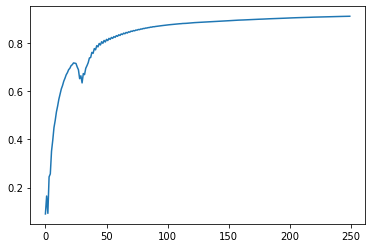

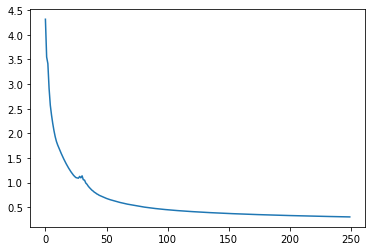

In [13]:
a = plt.plot(accuracies)
plt.show()
l = plt.plot(losses)
plt.show()

## Test Accuracy

In [14]:
output = model.forward(x_test)
accuracy = np.round(model.accuracy(y_test) * 100, 2)
loss = np.round(model.loss(y_test), 4)
print(f'Accuracy: {accuracy}% Loss: {loss}')

Accuracy: 91.99% Loss: 0.2896
